In [18]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.ndimage import binary_fill_holes
from skimage._shared.filters import gaussian
from skimage.color import label2rgb
from skimage.exposure import equalize_adapthist
from skimage.exposure import rescale_intensity
from skimage.filters import unsharp_mask
from skimage.measure import find_contours
from skimage.measure import label, regionprops_table
from skimage.morphology import binary_closing, disk
from skimage.morphology import binary_opening, binary_erosion, remove_small_objects, convex_hull_image, binary_dilation

from src.filters import sobel, yen_th, normalize_0_255
from src.fish.find_fish_props import refine_oversized_hull
from src.fish.is_fish import is_fish
from src.fish.remove_background import remove_bg
from src.fish.well_meniscus import get_menisc
from src.models import InputImage
from src.utils import keep_largest_object
from src.well.find_well_props import find_well_props

# Init input image & find well

In [19]:
input_img = InputImage("zf2.jpg")
input_img.processed = normalize_0_255(input_img.processed)
input_img.processed = np.uint8(input_img.processed)
input_img = find_well_props(input_img)

# Searching for well properties
_____________________________________________________________
# Hough-transformation for the well
_____________________________________________________________
# Hough-transformation finished
_____________________________________________________________
# Creating circle mask for well
_____________________________________________________________
# Circle mask for well created
_____________________________________________________________
# Creating remaining masks:
_____________________________________________________________
# Creating cropped mask
_____________________________________________________________
# Creating masked image (original)
_____________________________________________________________
# Creating masked image (cropped)
_____________________________________________________________
# Created remaining masks
_____________________________________________________________
# Finished searching for well properties
_____________________________

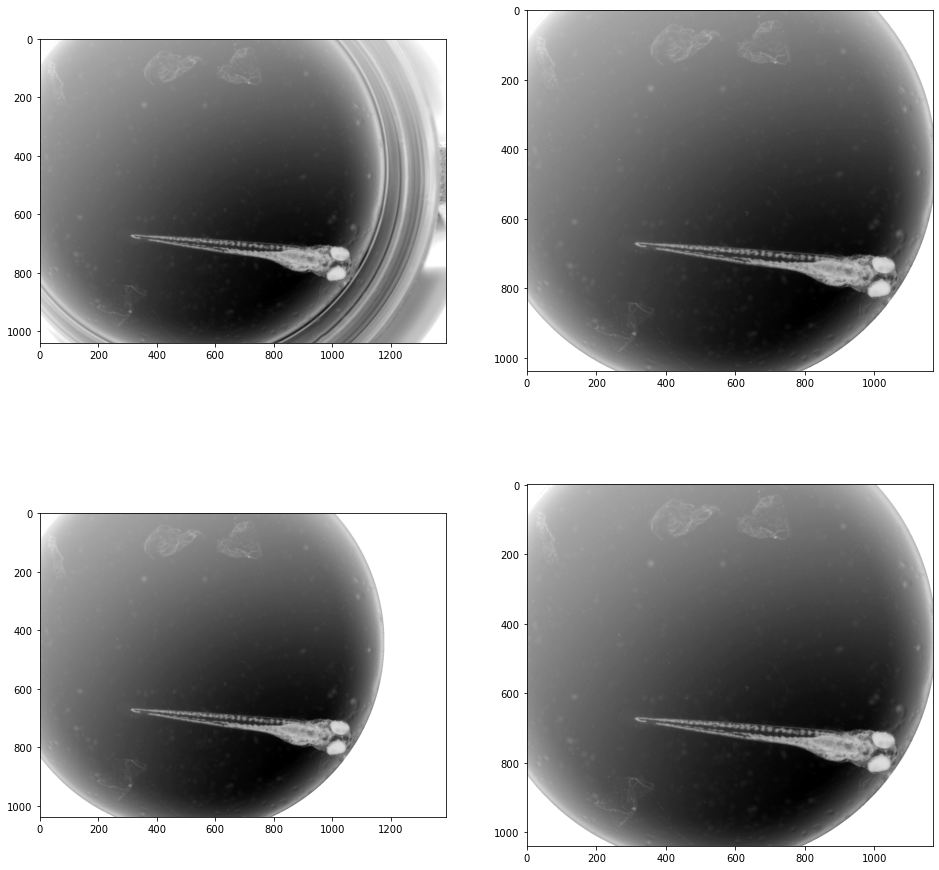

In [20]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 16))
ax = ax.ravel()

ax[0].imshow(input_img.og, 'binary')
ax[1].imshow(input_img.processed, 'binary')
ax[2].imshow(input_img.well_props.mask.masked, 'binary')
ax[3].imshow(input_img.well_props.mask.cropped_masked, 'binary')

______________________________________________________________________
### (Remove background)

In [21]:
"""ri = equalize_adapthist(input_img.well_props.mask.cropped_masked)
r_bg = remove_bg(ri, inverted=False)
r_bg_i = remove_bg(ri, inverted=True)

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 16))
ax = ax.ravel()
ax[0].imshow(input_img.well_props.mask.cropped_masked, 'binary')
ax[1].imshow(ri, 'binary')
ax[2].imshow(equalize_adapthist(r_bg), 'binary')
ax[3].imshow(r_bg_i, 'binary')"""

"ri = equalize_adapthist(input_img.well_props.mask.cropped_masked)\nr_bg = remove_bg(ri, inverted=False)\nr_bg_i = remove_bg(ri, inverted=True)\n\nfig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 16))\nax = ax.ravel()\nax[0].imshow(input_img.well_props.mask.cropped_masked, 'binary')\nax[1].imshow(ri, 'binary')\nax[2].imshow(equalize_adapthist(r_bg), 'binary')\nax[3].imshow(r_bg_i, 'binary')"

___________________________________________________________________

# Unsharp masking and sobel kernel for edge detection

<class 'numpy.ndarray'>
uint8
(1040, 1168)
float64


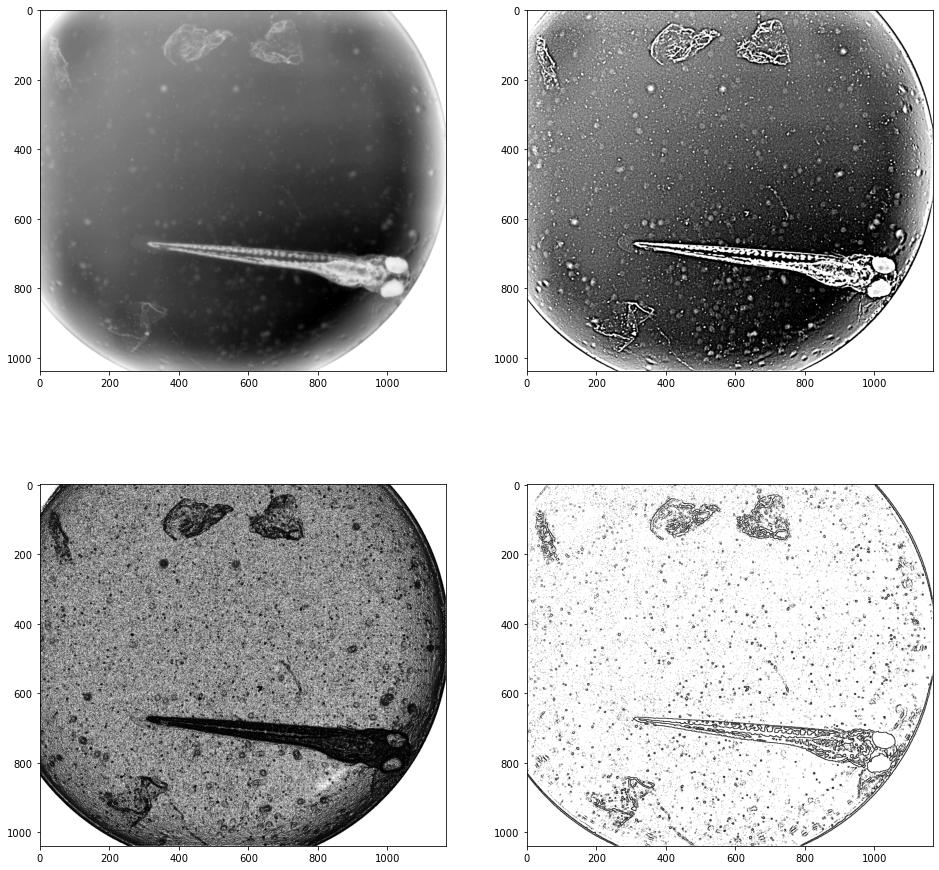

In [22]:
print(type(input_img.processed))
print(input_img.processed.dtype)
print(input_img.processed.shape)

input_img.processed = input_img.well_props.mask.cropped_masked

gauss = gaussian(input_img.processed, 1)

sob = sobel(input_img.processed)  # (input_img.processed)

eq_ = equalize_adapthist(gauss)
um_ = unsharp_mask(eq_, amount=20, radius=3)
new_sob = sobel(um_)

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 16))
ax = ax.ravel()

print(um_.dtype)

ax[0].imshow(eq_, 'binary')
ax[1].imshow(um_, 'binary')
ax[2].imshow(sob, 'binary')
ax[3].imshow(new_sob, 'binary')

In [23]:
# try_all_threshold(new_sob, figsize=(16, 16), verbose=False)

# Yen thresholding and binary morphological manipulations

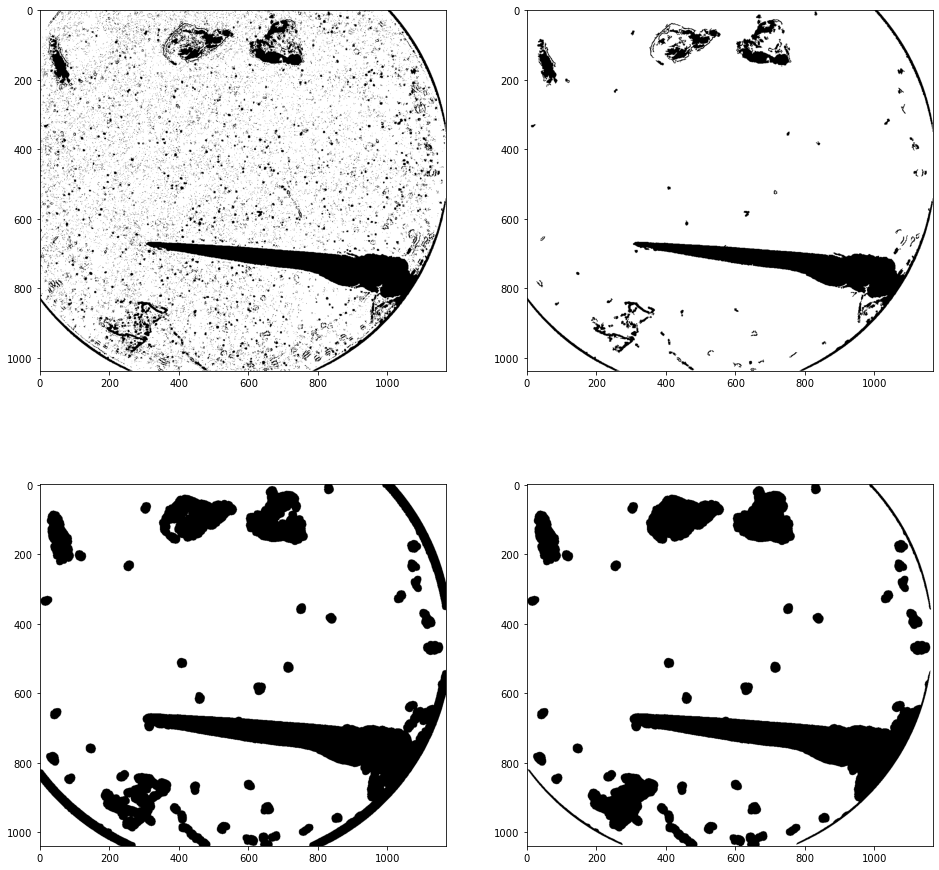

In [24]:
th = yen_th(new_sob)
th = binary_fill_holes(th)

op = remove_small_objects(th)
dil = binary_dilation(remove_small_objects(op), disk(10))
closed = binary_closing(dil, disk(1))

filled = binary_fill_holes(closed)
filled_masked = filled * input_img.well_props.mask.cropped

input_img.processed = filled_masked

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 16))
ax = ax.ravel()
ax[0].imshow(th, 'binary')
ax[1].imshow(op, 'binary')
ax[2].imshow(dil, 'binary')
ax[3].imshow(filled_masked, 'binary')

______________________________________________________________________
### (Remove meniscus)


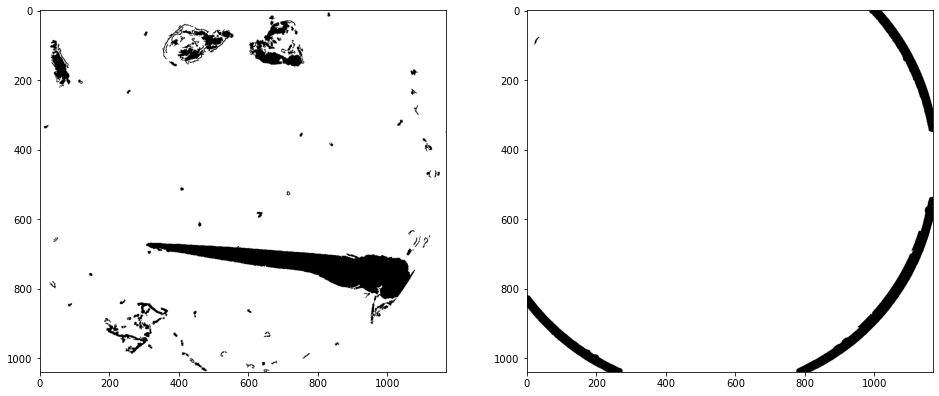

In [25]:
meniscus = get_menisc(dil, input_img.well_props.mask.cropped_masked)
res = ~meniscus * op

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 16))
ax = ax.ravel()
ax[0].imshow(res, 'binary')
ax[1].imshow(meniscus, 'binary')

_____________________________________________________

# Convex hull & covex hull refinement

# Finding largest object
_____________________________________________________________
# Finding largest object
_____________________________________________________________
IS FISH!


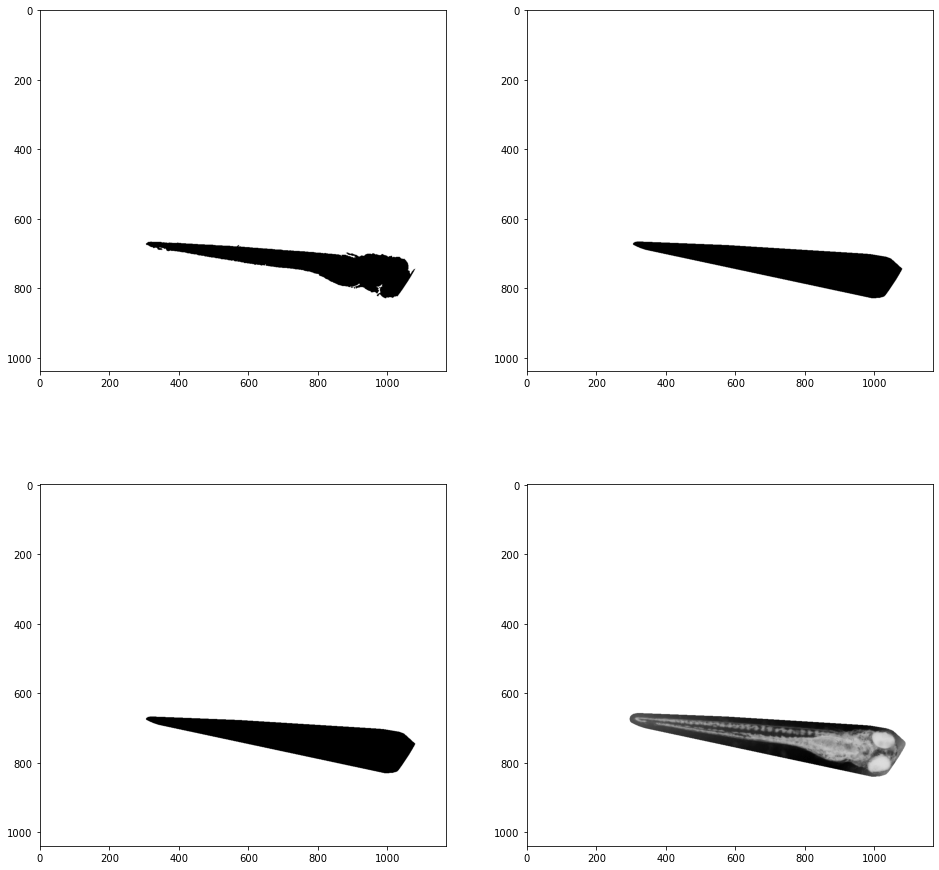

In [26]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 16))
ax = ax.ravel()

klo = keep_largest_object(res)  #(filled_masked)
fish_mask = convex_hull_image(klo).astype(bool)

input_img.fish_props.mask.og = fish_mask

for i in range(6):
    if is_fish(input_img.fish_props.mask.og):
        break
    input_img = refine_oversized_hull(input_img, step=i + 1)

dilated_mask = binary_dilation(input_img.fish_props.mask.og, disk(10))
input_img.fish_props.mask.masked = dilated_mask * input_img.well_props.mask.cropped_masked
dilated_masked = input_img.fish_props.mask.masked

ax[0].imshow(klo, 'binary')
ax[1].imshow(fish_mask, 'binary')
ax[2].imshow(input_img.fish_props.mask.og, 'binary')
ax[3].imshow(dilated_masked, 'binary')

# Refine fish mask

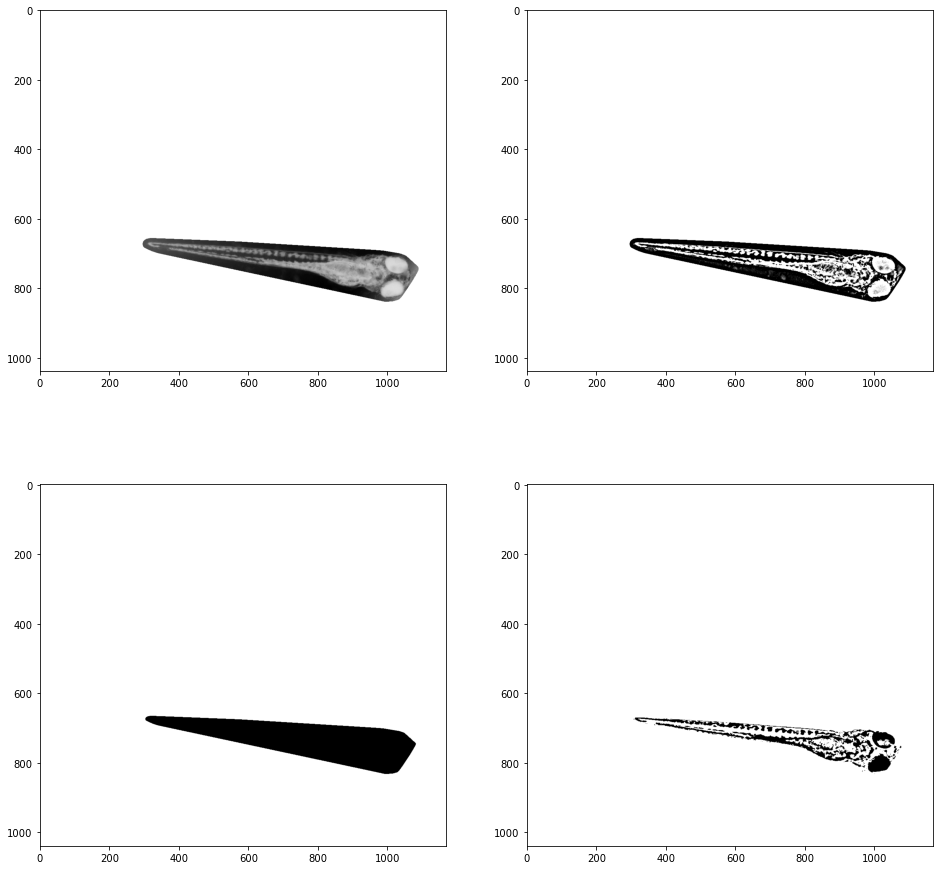

In [27]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 16))
ax = ax.ravel()

um = unsharp_mask(rescale_intensity(dilated_masked), amount=20, radius=4)

eroded_mask = binary_erosion(dilated_mask, disk(8))

refined = remove_small_objects(yen_th(um))
refined = ~refined * eroded_mask

ax[0].imshow(dilated_masked, 'binary')
ax[1].imshow(um, 'binary')
ax[2].imshow(eroded_mask, 'binary')
ax[3].imshow(binary_fill_holes(refined) * dilated_mask, 'binary')

# Filling & eliminating small objects

# Finding largest object
_____________________________________________________________


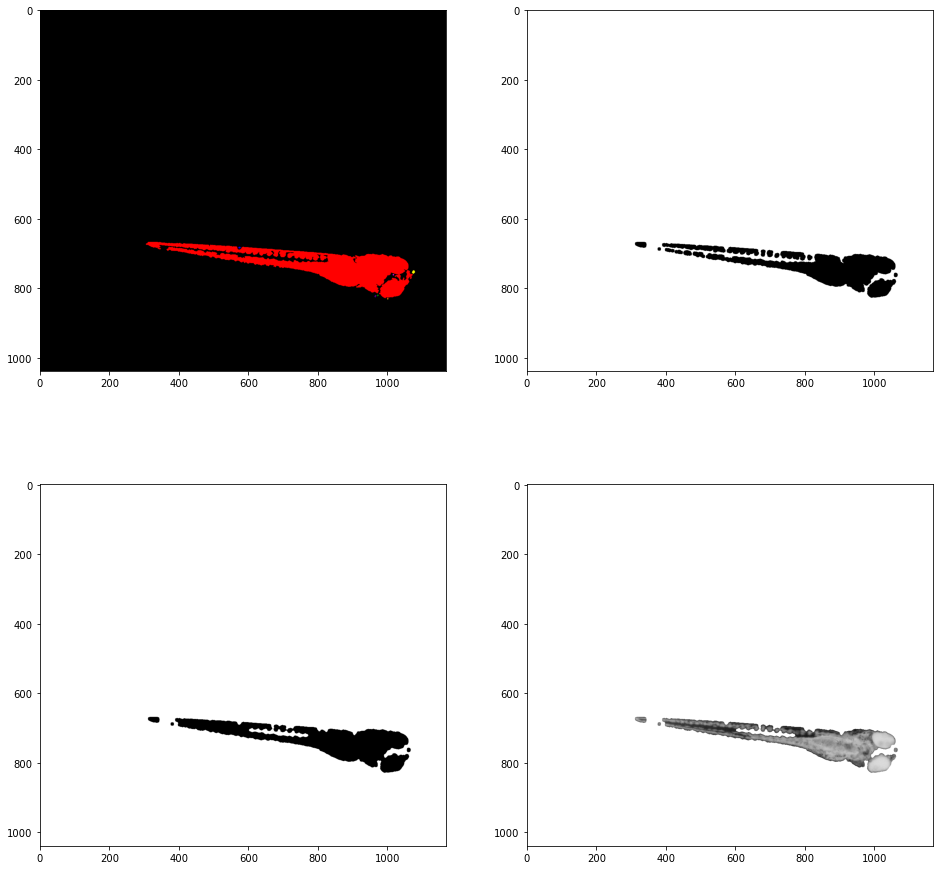

In [28]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 16))
ax = ax.ravel()

labeled = label(binary_fill_holes(binary_dilation(refined, disk(2))))
keeps = keep_largest_object(labeled)
props = regionprops_table(labeled, properties=('label', 'area', 'image_filled'))

opened = binary_opening(binary_fill_holes(keeps), disk(5))
closed = binary_fill_holes(binary_closing(remove_small_objects(opened.astype(bool)), disk(3)))
refined_ = binary_fill_holes(closed)

refined__ = refined_ * input_img.well_props.mask.cropped_masked

ax[0].imshow(label2rgb(labeled), 'binary')
ax[1].imshow(opened, 'binary')
ax[2].imshow(closed, 'binary')
ax[3].imshow(refined__, 'binary')

# Drawing contours of the fish mask

# Finding largest object
_____________________________________________________________
# Finding largest object
_____________________________________________________________


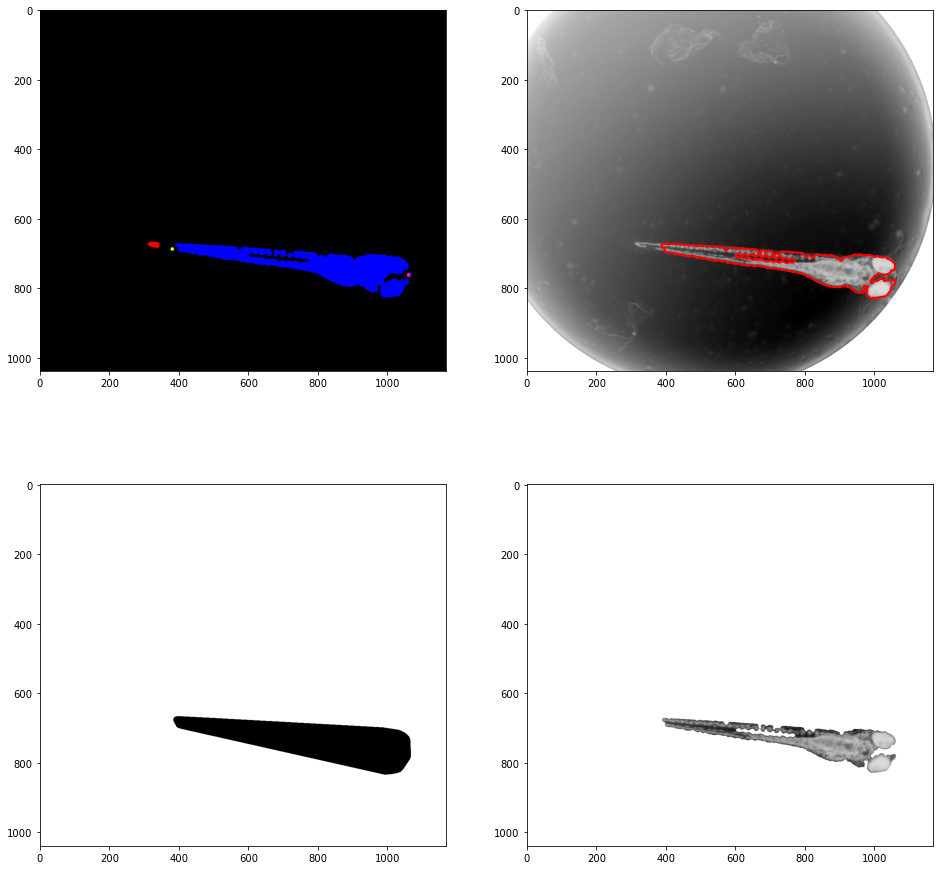

In [29]:
#labeled = label(input_img.fish_props.mask.og * binary_closing(fishy, disk(5)))
labeled = label(refined__.astype(bool))
props = regionprops_table(labeled, properties=('label', 'bbox', 'area'))

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 16))
ax = ax.ravel()

largest_label = keep_largest_object(labeled)
hull = convex_hull_image(keep_largest_object(labeled))
hull = binary_dilation(hull, disk(5))

contour = find_contours(largest_label)

ax[0].imshow(label2rgb(labeled))
ax[1].imshow(input_img.well_props.mask.cropped_masked, 'binary')
ax[2].imshow(hull, 'binary')
ax[3].imshow(largest_label * input_img.well_props.mask.cropped_masked, 'binary')

for cont in contour:
    ax[1].plot(cont[:, 1], cont[:, 0], linewidth=2, color='red')

_____________________________________________________

# Convex hull & covex hull refinement

# Finding largest object
_____________________________________________________________
# Finding largest object
_____________________________________________________________
IS FISH!


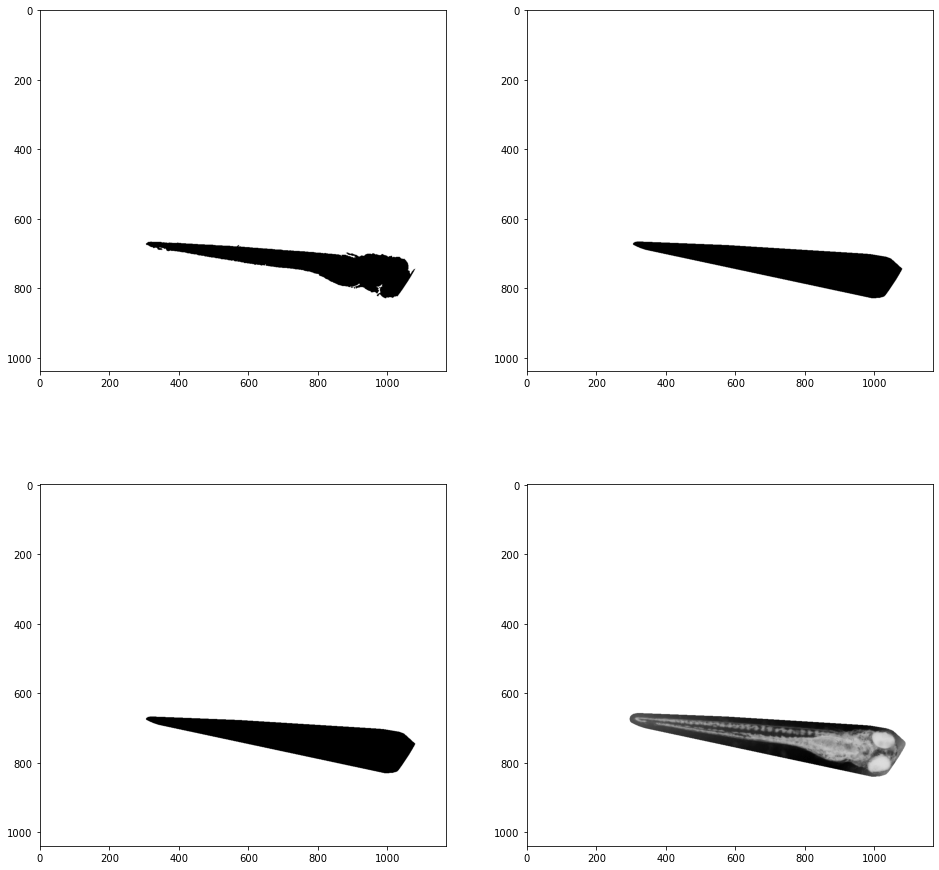

In [30]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 16))
ax = ax.ravel()

klo = keep_largest_object(res)  #(filled_masked)
fish_mask = convex_hull_image(klo).astype(bool)

input_img.fish_props.mask.og = fish_mask

for i in range(6):
    if is_fish(input_img.fish_props.mask.og):
        break
    input_img = refine_oversized_hull(input_img, step=i + 1)

dilated_mask = binary_dilation(input_img.fish_props.mask.og, disk(10))
input_img.fish_props.mask.masked = dilated_mask * input_img.well_props.mask.cropped_masked
dilated_masked = input_img.fish_props.mask.masked

ax[0].imshow(klo, 'binary')
ax[1].imshow(fish_mask, 'binary')
ax[2].imshow(input_img.fish_props.mask.og, 'binary')
ax[3].imshow(dilated_masked, 'binary')

# Refine fish mask

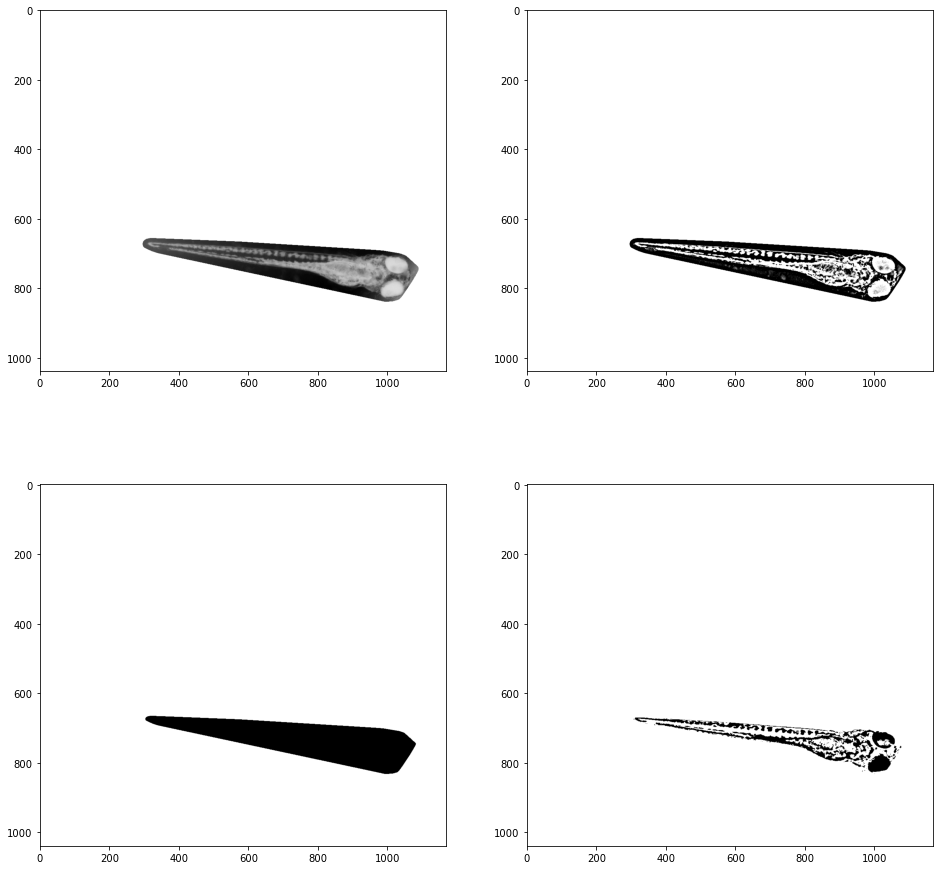

In [31]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 16))
ax = ax.ravel()

um = unsharp_mask(rescale_intensity(dilated_masked), amount=20, radius=4)

eroded_mask = binary_erosion(dilated_mask, disk(8))

refined = remove_small_objects(yen_th(um))
refined = ~refined * eroded_mask

ax[0].imshow(dilated_masked, 'binary')
ax[1].imshow(um, 'binary')
ax[2].imshow(eroded_mask, 'binary')
ax[3].imshow(binary_fill_holes(refined) * dilated_mask, 'binary')

# Filling & eliminating small objects

# Finding largest object
_____________________________________________________________


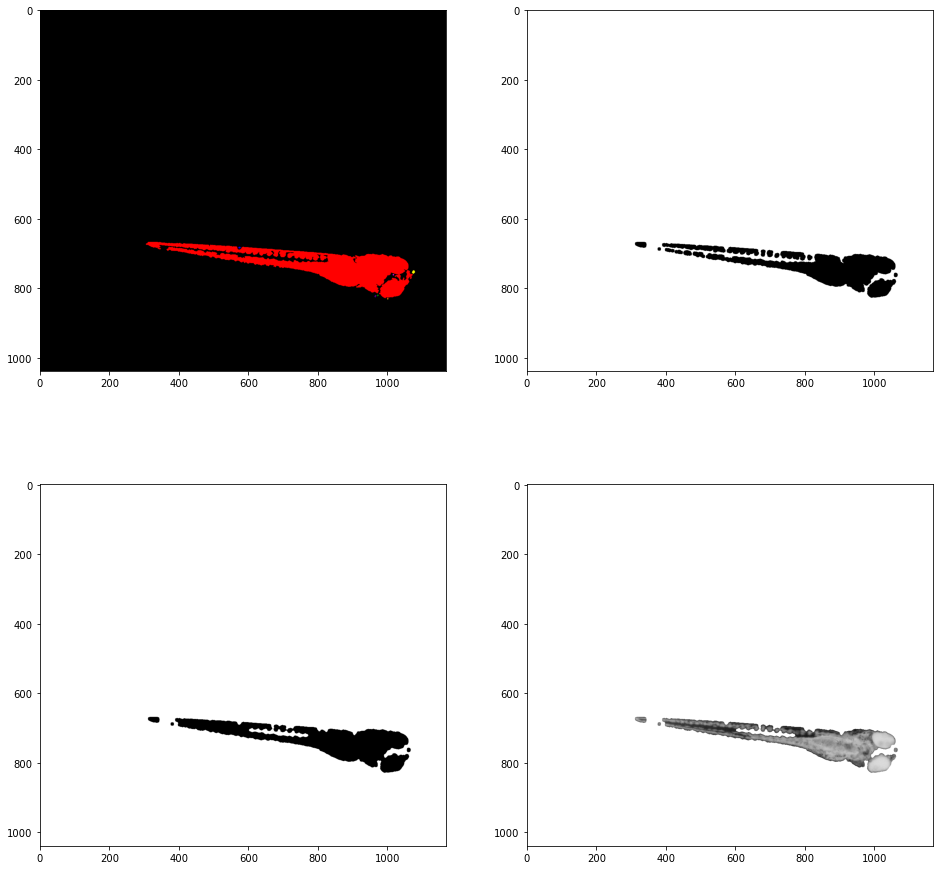

In [32]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 16))
ax = ax.ravel()

labeled = label(binary_fill_holes(binary_dilation(refined, disk(2))))
keeps = keep_largest_object(labeled)
props = regionprops_table(labeled, properties=('label', 'area', 'image_filled'))

opened = binary_opening(binary_fill_holes(keeps), disk(5))
closed = binary_fill_holes(binary_closing(remove_small_objects(opened.astype(bool)), disk(3)))
refined_ = binary_fill_holes(closed)

refined__ = refined_ * input_img.well_props.mask.cropped_masked

ax[0].imshow(label2rgb(labeled), 'binary')
ax[1].imshow(opened, 'binary')
ax[2].imshow(closed, 'binary')
ax[3].imshow(refined__, 'binary')

# Drawing contours of the fish mask

# Finding largest object
_____________________________________________________________
# Finding largest object
_____________________________________________________________


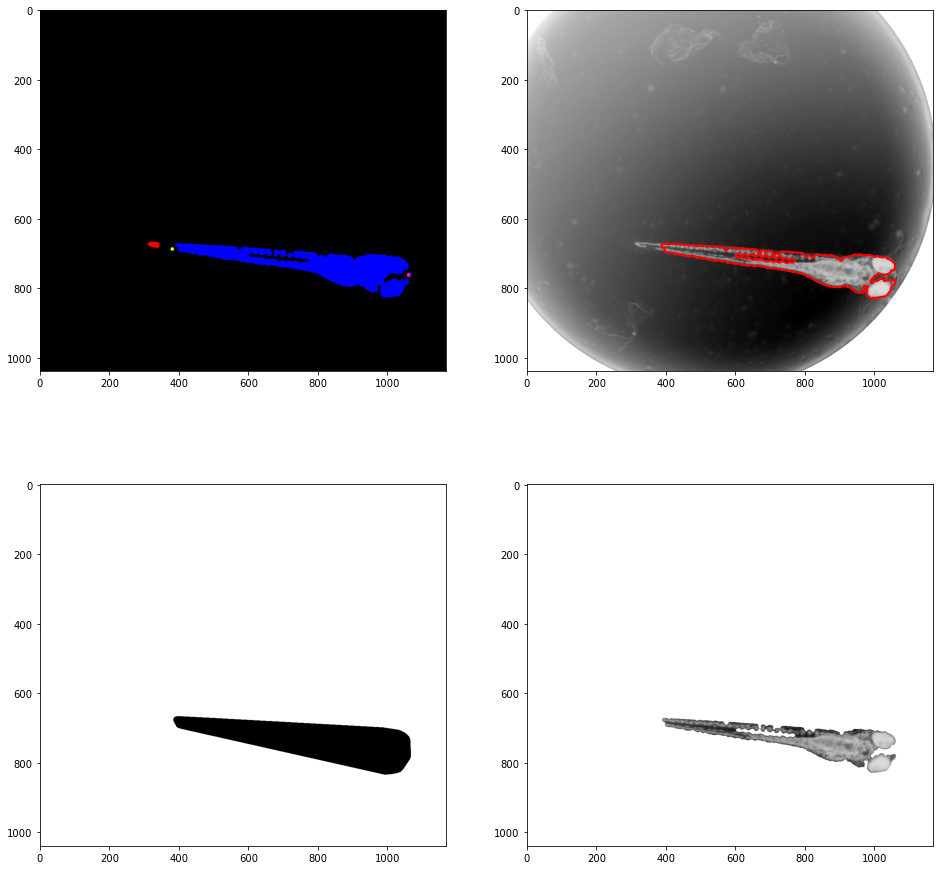

In [33]:
#labeled = label(input_img.fish_props.mask.og * binary_closing(fishy, disk(5)))
labeled = label(refined__.astype(bool))
props = regionprops_table(labeled, properties=('label', 'bbox', 'area'))

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 16))
ax = ax.ravel()

largest_label = keep_largest_object(labeled)
hull = convex_hull_image(keep_largest_object(labeled))
hull = binary_dilation(hull, disk(5))

contour = find_contours(largest_label)

ax[0].imshow(label2rgb(labeled))
ax[1].imshow(input_img.well_props.mask.cropped_masked, 'binary')
ax[2].imshow(hull, 'binary')
ax[3].imshow(largest_label * input_img.well_props.mask.cropped_masked, 'binary')

for cont in contour:
    ax[1].plot(cont[:, 1], cont[:, 0], linewidth=2, color='red')